In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import spectral
from sklearn import preprocessing
from sklearn.cluster import KMeans 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import joblib

#### pca降维操作

In [2]:
def pca_hpi(input_image, dimension=30):
    spectral = list()
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            spectral.append(input_image[i][j,])
    spectral_array = np.array(spectral)
    ## 降维
    pca = PCA(n_components=dimension)
    pca.fit(spectral_array)
    pca_input_iamge = pca.transform(spectral_array)
    ## 姜维之后恢复 原来形状
    pca_return_array = np.vsplit(pca_input_iamge,input_image.shape[0])
    pca_return_array = np.array(pca_return_array)
    print (pca.explained_variance_ratio_)
    return pca_return_array

#### 提取一个channel的空间

In [3]:
# 可以提取出高光谱数据的一个channel的数据 145*145
def split_one_channel(A,channel):
    d = [0]*A.shape[0]
    for i in range(len(d)):
        d[i] = A[i][:,channel-1]
    e = np.vstack((d[i] for i in range(len(d))))
    return e  
# 参数说明
# channel 通道
# A 高光谱立方块


# 依据patch大小（Filter 大小）对矩阵进行镜像处理
def mirror_matrix(A, fil):
    pad = int((fil-1)/2)
    for  i in range(1,pad+1):
        up = np.array(A[2*i-1,:])
        down = np.array(A[-2*i,:])
        Matrix_up_down = np.vstack([up,A,down])
        left = np.array(Matrix_up_down[:,2*i-1]).reshape(len(Matrix_up_down),1)
        right = np.array(Matrix_up_down[:,-2*i]).reshape(len(Matrix_up_down),1)
        Matrix_left_right = np.hstack([left,Matrix_up_down,right,])
        A = Matrix_left_right
    return A

# 参数说明
# n   array size
# fil  filter size5*5
# pad = (fil-1)/2  padding大小


# 将镜像处理后的矩阵进行向量化操作
def split_array(A,fil):
    s = []
    row = len(A)-fil+1
    col = len(A[0])-fil+1
    for i in range(row): # row
        for j in range(col): # col
            temp = [0]* fil
            for z in range(fil):
                temp[z] = A[i+z,j:j+fil]
            com = np.concatenate(temp)
            s.append(com)
    return s 
# 参数说明
# A 镜像处理后的矩阵
# fil  filter size


# 计算欧几里得距离
def Euclidean(v1,v2):
    return np.linalg.norm(v1-v2)


# 计算单个patch的空间信息
def patch_spitial(v1, K_centroid):
    distance_array = np.array([Euclidean(v1, centroid) for centroid in K_centroid]) #距离matrix
    sums = np.sum(distance_array)
    average = np.average(distance_array)
    spitial_one_patch = np.maximum(0,average - distance_array) #依据公式求空间信息
    return spitial_one_patch

# 对一个channel的求解进行向量化
def channel_spitial(channel_matrix, K_centroid):
    channel_spitial_list = list()
    for i in range(len(channel_matrix)):
        channel_spitial_list.append(patch_spitial(channel_matrix[i], K_centroid))
    return np.array(channel_spitial_list)

#### 整体求解

In [4]:
# 构造n个通道的向量
def create_whole_vector(dim,fil,input_image):
    whole_origin_matrix_array = np.array([split_one_channel(input_image,i) for i in range(1,dim+1)])
    whole_mirror_matrix_array = np.array([mirror_matrix(whole_origin_matrix_array[i],fil) for i in range(dim)])
    whole_split_matrix_array = np.array([split_array(whole_mirror_matrix_array[i],fil) for i in range(dim)])
    return whole_split_matrix_array


## 通过k-means求解 whole_K_centroid
K =5 # K个中心
def create_centroid(K,dim,whole_split_matrix_array):
    # 返回dim个k-means对象
    whole_kmeans = [KMeans(n_clusters=K, random_state=0).fit(whole_split_matrix_array[i]) for i in range(dim)]
    whole_K_centroid = [whole_kmeans[i].cluster_centers_ for i in range(dim) ]
    return whole_K_centroid

## 求整体空间信息
def create_spe_spi(whole_K_centroid,whole_split_matrix_array):
    whole_temp = list()
    for i in range(len(whole_K_centroid)):
        whole_temp.append(channel_spitial(whole_split_matrix_array[i],whole_K_centroid[i]))
    whole_spitial = np.array(whole_temp)
    return whole_spitial


###### 可选操作，将spectral-spitial信息以numpy形式保存
def save_spe_spi(whole_spitial,path='I:\data\whole_spitial.npy'):
    np.save(path,whole_spitial)
###### 可选操作，载入数据
def load_spe_spi(name):
    s = np.load(name)
    return s

## 合成sample_with_lables
def sample_with_lables(s,dim,output_image):
    sample = np.hstack([s[i]for i in range(dim)])
    label = output_image.reshape(len(sample),1)
    sample_lb = np.hstack([sample,label])
    return sample_lb


## 提取出需要分类的数据
def need_claasify(sample_lb):
    sample_lab_fix_list = list()
    for i in range(len(sample_lb)):
        if sample_lb[i,-1] != 0:
            sample_lab_fix_list.append(sample_lb[i,:])
    sample_lab_fix = np.array(sample_lab_fix_list)
    return sample_lab_fix


## 将数据归一化并且存储：
def scaler_save(sample_lab_fix, path = 'H:\data\spec_spi.csv'):
    ## 归一化
    data_D = preprocessing.StandardScaler().fit_transform(sample_lab_fix[:,:-1])
    data_L = sample_lab_fix[:,-1]

    ## 存储
    new = np.column_stack((data_D, data_L))
    new_ = pd.DataFrame(new)
    new_.to_csv(path,header=False,index=False)
    

## 分类数据提取
def classify_pre(path='H:\data\spec_spi.csv'):
    data = pd.read_csv(path,header=None)
    data = data.as_matrix()
    data_D = data[:,:-1]
    data_L = data[:,-1]
    data_train, data_test, label_train, label_test = train_test_split(data_D,data_L,test_size=0.9)
    return data_train, data_test, label_train, label_test

#### 分类进行

In [5]:
## 设置初始值
DIM = 30
FIL = 5
K = 5

In [6]:
input_image = loadmat('I:\data\Indian_pines_corrected.mat')['indian_pines_corrected']
output_image = loadmat('I:\data\Indian_pines_gt.mat')['indian_pines_gt']

In [7]:
## 降维操作
pca_return_array = pca_hpi(input_image,DIM)
pca_return_array.shape

[6.84937994e-01 2.35313708e-01 1.49635476e-02 8.21541515e-03
 6.95011265e-03 5.17010703e-03 3.99681431e-03 3.62359687e-03
 3.07127396e-03 2.93211894e-03 2.67352983e-03 2.49230108e-03
 2.24688362e-03 1.89388746e-03 1.69433602e-03 1.56043465e-03
 1.53162479e-03 1.35012943e-03 1.00138897e-03 9.24873500e-04
 8.47861916e-04 7.64353557e-04 6.64545881e-04 6.45648500e-04
 6.16261109e-04 5.61399621e-04 5.43096741e-04 5.15460020e-04
 4.20751518e-04 3.62948615e-04]


(145, 145, 30)

In [8]:
## 对30维高光谱数据进行向量化操作处理
whole_split_matrix_array = create_whole_vector(DIM,FIL,pca_return_array) 
whole_split_matrix_array.shape

(30, 21025, 25)

In [16]:
## 通过k-means求解空间前置信息
whole_K_centroid = create_centroid(FIL,DIM,whole_split_matrix_array)
len(whole_K_centroid)  # 30x5x25

30

In [15]:
len(whole_K_centroid[0][0])

25

In [10]:
# 通过欧几里得距离求解空谱信息
whole_spitial = create_spe_spi(whole_K_centroid,whole_split_matrix_array)
whole_spitial.shape  # 验证空谱信息提出成功

(30, 21025, 5)

In [11]:
save_spe_spi(whole_spitial,'I:\data\whole_spitial.npy')   ##将空谱信心保存为numpy格式

In [12]:
spec_spi = load_spe_spi('I:\data\whole_spitial.npy')  # 将空谱信息载入

In [13]:
# 验证数据集正确性
spec_spi.shape

(30, 21025, 5)

In [14]:
# 合成带有标签的样本
sample_lb = sample_with_lables(spec_spi,DIM,output_image)
sample_lb.shape

(21025, 151)

In [15]:
## 提取需要分类的样本
sample_lab_fix = need_claasify(sample_lb)
sample_lab_fix.shape

(10249, 151)

In [18]:
# 归一化后保存
scaler_save(sample_lab_fix, path = 'I:\data\pca_spec_spic_30.csv') 

NameError: name 'sample_lab_fix' is not defined

In [17]:
 #分类前置操作
data_train, data_test, label_train, label_test = classify_pre(path='I:\data\pca_spec_spic_30.csv')

#### 执行分类

In [18]:
# clf = lgb.LGBMClassifier()

clf = SVC(kernel='linear')

# # clf = XGBClassifier(max_depth=20,learning_rate=0.3,n_estimators=500,silent=False,
#                        objective='multi:softmax',
#                         min_child_weight=1,
#                         gamma=0.,
#                         scale_pos_weight=1)

# clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.5,
#      max_depth=20, random_state=0)
# clf = AdaBoostClassifier(
#     SVC(kernel='linear'),
#     n_estimators=2,
#     learning_rate=1,
#     algorithm="SAMME")

clf.fit(data_train,label_train)
pred = clf.predict(data_test)
accuracy = metrics.accuracy_score(label_test, pred)*100
print(accuracy)
# acc = clf.score(data_test, label_test)
# print(acc)
joblib.dump(clf,"I:\model\pca_specr_spi_30.m")

89.84281842818427


['I:\\model\\pca_specr_spi_30.m']

#### 绘制分类图形状

In [19]:
# 新图像形状
new_show = np.zeros((output_image.shape[0], output_image.shape[1]))
new_show.shape

(145, 145)

In [20]:
## 提取所有数据
testdata = np.genfromtxt('I:\data\pca_spec_spic_30.csv',delimiter=',')
data_test = testdata[:,:-1]
label_test = testdata[:,-1]
print(data_test.shape)
print(label_test.shape)

(10249, 150)
(10249,)


In [21]:
#提取分类器并分类
clf = joblib.load('I:\model\pca_specr_spi_30.m')
predict_label = clf.predict(data_test)
accuracy = metrics.accuracy_score(label_test,predict_label)*100
print (accuracy)

90.85764464825836


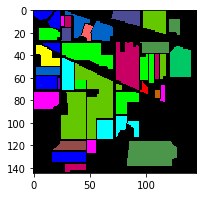

In [22]:
# 原图
ground_truth = spectral.imshow(classes = output_image.astype(int),figsize =(3,3))

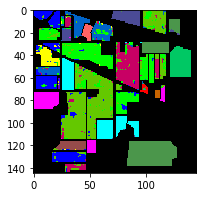

In [23]:
# 构造分类图
k = 0
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if output_image[i][j] != 0:
            new_show[i][j] = predict_label[k]
            k += 1
# 分类效果图
ground_truth = spectral.imshow(classes = new_show.astype(int),figsize =(3,3))